# Projektarbeit: Klassifikation von Tierbildern mittels CNN

Es soll ein CNN-Modell trainiert werden, mit dem es möglich ist Tierbilder zu klassifizieren. Als Trainingsdaten stehen insgesamt 26195 Bilder 10 veschiedener Klassen zur Verfügung. Vor dem eigentlichen Laden der Daten und dem folgendem Training des Modells müssen Bildduplikate gefunden und entfernt werden.



# Schritt 0: "Organisatorische" Vorbereitungen
## Definition der Arbeitspfade

In [1]:
#Import of necessary functions
import os

#Set work directory, dataset-folders need to be placed in project-directory!
rootDir = os.getcwd()

testDir = rootDir +  "\Dataset_Test\Images_Test"
trainDir = rootDir + "\Dataset_Train_Eval\Images"

print("rootDir:", rootDir)
print("testDir:", testDir)
print("trainDir:", trainDir)

rootDir: C:\Users\Riccardo\source\Projektarbeit
testDir: C:\Users\Riccardo\source\Projektarbeit\Dataset_Test\Images_Test
trainDir: C:\Users\Riccardo\source\Projektarbeit\Dataset_Train_Eval\Images


# Schritt 1: Entfernen von Duplikaten aus den Trainings-/Evaluierungsdaten
## Erfassen aller Pfade der Trainingsbilder

Es werden alle Dateipfade erfasst und in einer Liste gespeichert, um diese hinterher leichter per Index abrufbar zu machen, gleichzeitig kann anhand der Länge der Liste ermittelt werden wie viele Trainingsbilder insgesamt vorhanden sind.

In [2]:
#Import of necessary functions
import os

#set traindata directory as workdirectory
os.chdir(trainDir)

#Generate a list of all image-filepaths and image-names
filepaths=[]
names=[]

for root, dirs, files in os.walk("./", topdown=False):
    for name in files:
        filepaths.append(os.path.join(root, name))
        names.append(name)
        
print("Found", len(filepaths), " files")

Found files:  26195


## Anzeige der ersten fünf Bilder

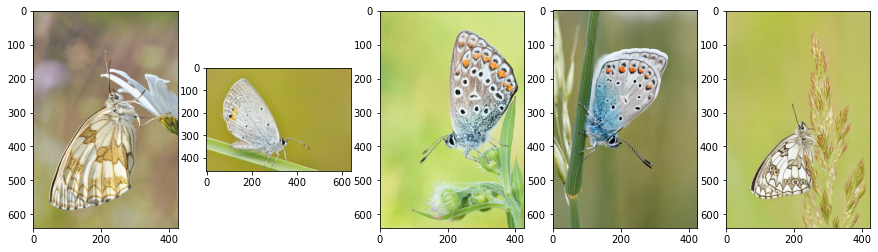

In [3]:
#Import of necessary functions
import matplotlib.pyplot as plt

#set figsize
figsize = (15, 15)

fig, axes = plt.subplots(1, 5, figsize = figsize)
for i in range (0, 5):
    Img = plt.imread (filepaths[i])
    axes[i].imshow(X = Img)
plt.show()

## Hashbildung & Vergleich

Um Bilder als Duplikat idenifizieren zu können muss zu jedem Bild eine Hashsumme gebildet werden.

Mittels OpenCV wird zunächst ein Bild geladen, in Graustufen konvertiert und verkleinert. Mittels der Graustufung wird erreicht, dass nur ein Farbkanal anstatt von drei berücksichtigt werden müssen und der Rechenaufwand deutlich verringert wird.
Durch die Skalierung auf ein 8x8 Bild resultiert am Ende ein 64bit Hash.

Der Hashwert wird nun anhand des horizontalen Gradienten gebildet: Es wird geprüft, ob der folgende Pixel einen höheren Wert aufweist als der aktuell betrachtete, hieraus ergibt sich eine Matrix aus True- und False-Werten.
Ist das i-te Feld der Matrize True, wird 2 mit i potenziert. Die Summe aller Produkte ergibt den Hash.


In [4]:
#Import of necessary functions
import cv2 as cv

def dhash(image, hashSize = 8):
    # resize the image, adding a single column (width) so we can compute the horizontal gradient
    resized = cv.resize(image, (hashSize + 1, hashSize))

    # compute the (relative) horizontal gradient between adjacent column pixels
    diff = resized[:, 1:] > resized[:, :-1]

    # convert the difference image to a hash
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [5]:
#Import of necessary functions
import cv2 as cv

count = 0
hashSet = [] #List of generated hashes to compare

#lists "original" and "duplicates" used later to show the first five matches
original = []
duplicate = []

duplicateDir = rootDir + '\duplicates'
if (os.path.exists(duplicateDir)==False):
    os.mkdir(duplicateDir)

for i in range(len(filepaths)):
    #open image, grayscale, resize and build hash
    img = cv.imread(filepaths[i])
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    hash = dhash(imgGray)
    
    #compare the builded hash with the hashes of the list "hashSet"
    for j in range(len(hashSet)):
        if hash == hashSet[j]:
            #try-except needed because the for loop don't increment reliably in higher dimensions 
            try:
                os.rename(filepaths[i], duplicateDir + '\\' + names[i])
                count += 1
                original.append(filepaths[j])
                duplicatePath = duplicateDir + '\\' + names[i]
                duplicate.append(duplicatePath)
            except OSError:
                print("File already moved:", filepaths[i])
    hashSet.append(hash) #add the newest hash to the list.
    
print("Found", count, "duplicates")    

File already moved:  ./000000001-butterfly\OIP-HgMK6R2_M1j8fNMkEINGdgHaGr.jpeg
File already moved:  ./000000001-butterfly\OIP-I92aPPVQj3pcPXp8Y2hIJgHaGr.jpeg
File already moved:  ./000000001-butterfly\OIP-I92aPPVQj3pcPXp8Y2hIJgHaGr.jpeg
File already moved:  ./000000001-butterfly\OIP-IyajAknJhWGAfVEQaXIOZgHaE6.jpeg
File already moved:  ./000000002-cat\489.jpeg
File already moved:  ./000000008-sheep\OIP-VIPFTcaZxgDWvOkfsRZcJgHaFs.jpeg
File already moved:  ./000000010-squirrel\OIP-Zps-VUJrgjMr4b2rRNmWXgHaFI.jpeg
Found  104 duplicates


## Anzeige der ersten 5 Treffer

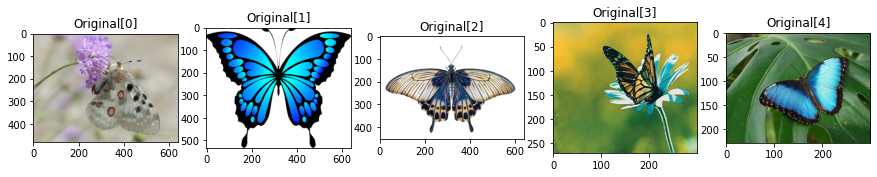

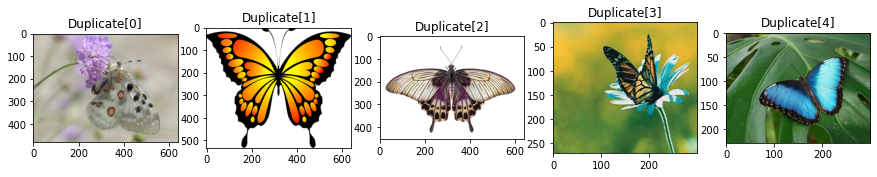

In [6]:
#Import of necessary functions
import matplotlib.pyplot as plt

#set figsize
figsize = (15, 15)

#function to show first 5 matches
def showMatches(ImgArray, ImgTitle):
    fig, axes = plt.subplots(1, 5, figsize = figsize)
    for i in range (0, 5):
        Img = plt.imread (ImgArray[i])
        axes[i].imshow(X = Img)
        axes[i].set(title = ImgTitle + '[' + str(i) + ']')
    plt.show()
    
showMatches(original, 'Original')
showMatches(duplicate, 'Duplicate')

# Schritt 2: Laden der Datenbank

In den kommenden Zeilen Code werden die Parameter/Einstellungen für die ImageDataGenerator und die flow_from_directory Funktionen eingestellt. Die Aufgabe des ImageDataGenera-tors ist es ein Batch von Bildern einzulesen und diese dann per Zufall zu skalieren, rotieren,spiegeln, strechen uvm. Diese werden dann die Originalen ersetzen.

Die flow_from_directory-Methode lädt die Dateien und weist das Label anhand der Ordnerstruktur zu.

In [7]:
#Import of necessary functions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Generate the ImageDataGenerator-Objects
rescale            = 1.0 / 255.0
validation_split   = 0.20
rotation_range     = 30
zoom_range         = 0.3
vertical_flip      = False
horizontal_flip    = True
width_shift_range  = [-10, 10]
height_shift_range = [-10, 10]
fill_mode          = 'nearest'
cval               = 0

train_datagen = ImageDataGenerator(rescale            = rescale,
                                   validation_split   = validation_split,
                                   rotation_range     = rotation_range,
                                   zoom_range         = zoom_range,
                                   vertical_flip      = vertical_flip,
                                   horizontal_flip    = horizontal_flip,
                                   width_shift_range  = width_shift_range,
                                   height_shift_range = height_shift_range,
                                   fill_mode          = fill_mode,
                                   cval               = cval)

eval_datagen = ImageDataGenerator(rescale            = rescale,
                                  validation_split   = validation_split)

test_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                  rotation_range=20,
                                  zoom_range=0.05,
                                  width_shift_range=0.05,
                                  height_shift_range=0.05,
                                  shear_range=0.05,
                                  horizontal_flip=True,
                                  fill_mode="nearest",
                                  validation_split=0.20)

In [8]:
#set parameters
ImgWidth    = 200
ImgHeight   = 200
ImgColor    = 'rgb'
target_size = (ImgHeight, ImgWidth)
class_mode  = 'categorical'
shuffle     = False
batch_size  = 32
seed        = 1
classes     = ['000000001-butterfly',
               '000000002-cat',
               '000000003-chicken',
               '000000004-cow',
               '000000005-dog',
               '000000006-elephant',
               '000000007-horse',
               '000000008-sheep',
               '000000009-spider',
               '000000010-squirrel']

train_generator = train_datagen.flow_from_directory(trainDir,
                                                    target_size=target_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode=class_mode,
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=42,
                                                    classes=classes)

eval_generator = eval_datagen.flow_from_directory(trainDir,
                                                        target_size=target_size,
                                                        color_mode="rgb",
                                                        batch_size=batch_size,
                                                        class_mode=class_mode,
                                                        subset='validation',
                                                        shuffle=True,
                                                        seed=42,
                                                        classes=classes)

test_generator = test_datagen.flow_from_directory(testDir,
                                                  target_size=target_size,
                                                  color_mode="rgb",
                                                  batch_size=1,
                                                  class_mode=None, #no class mode for test-data!
                                                  shuffle=False,
                                                  seed=42)

#print dimensions of the DataFrameIterator-Objects
print('len(train_generator):        ', len(train_generator))
print('len(eval_generator):         ', len(eval_generator))
print('train_generator[0][0].shape: ', train_generator[0][0].shape)
print('eval_generator[0][0].shape:  ', eval_generator[0][0].shape)
print('train_generator[0][1].shape: ', train_generator[0][1].shape)
print('eval_generator[0][1].shape:  ', eval_generator[0][1].shape)

Found 20876 images belonging to 10 classes.
Found 5215 images belonging to 10 classes.
Found 21 images belonging to 1 classes.
len(train_generator):         653
len(eval_generator):          163
train_generator[0][0].shape:  (32, 200, 200, 3)
eval_generator[0][0].shape:   (32, 200, 200, 3)
train_generator[0][1].shape:  (32, 10)
eval_generator[0][1].shape:   (32, 10)


## Anzeige der Original- und der vorverarbeiteten Daten:

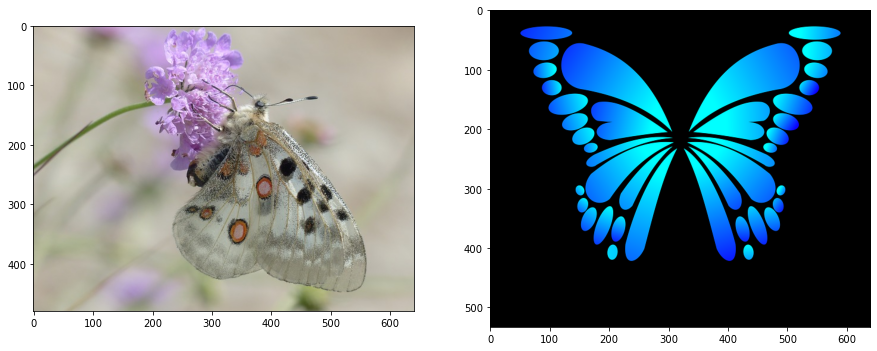

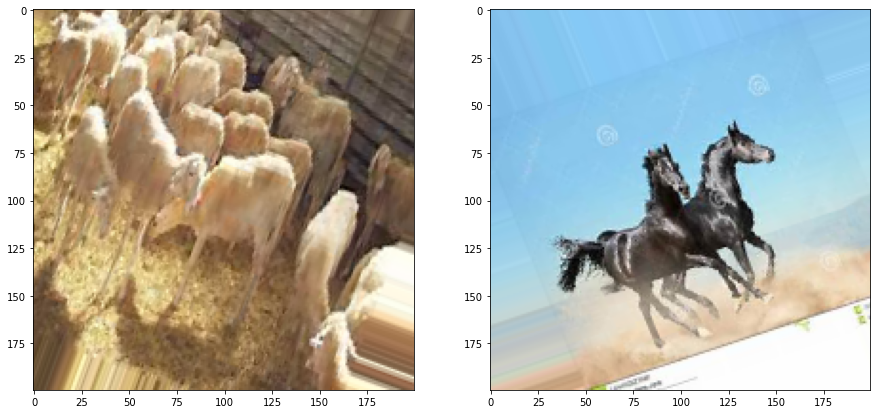

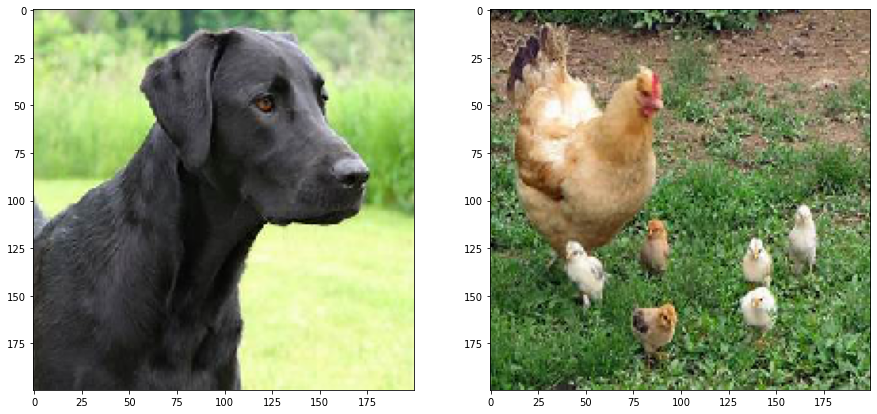

In [9]:
#Import of necessary functions
import cv2 as cv
import matplotlib.pyplot as plt
import os

#Loading of 2 original images
fig, axes         = plt.subplots(1, 2, figsize = (15, 15))

for i in range (0, 2):
    ImgMat    = cv.imread      (original[i])
    ImgMat    = cv.cvtColor    (ImgMat, cv.COLOR_BGR2RGB)
    axes[i].imshow             (X = ImgMat)
plt.show()

#loading of 2 preprocessed train images
fig, axes = plt.subplots(1, 2, figsize = (15, 15))
for i in range (0, 2):
    ImgMat    = train_generator[0][0][i]
    if    (ImgColor == 'rgb'):
        axes[i].imshow(X = ImgMat)
    elif  (ImgColor == 'grayscale'):
        axes[i].imshow(X = ImgMat, cmap = 'gray')
plt.show()

#loading of 2 preprocessed validation images
fig, axes = plt.subplots(1, 2, figsize = (15, 15))
for i in range (0, 2):
    ImgMat    = eval_generator[0][0][i]
    if    (ImgColor == 'rgb'):
        axes[i].imshow(X = ImgMat)
    elif  (ImgColor == 'grayscale'):
        axes[i].imshow(X = ImgMat, cmap = 'gray')
plt.show()

## Anzeige der ersten fünf Bilder je Datensatz

# Schritt 3: Parameterbestimmung des CNN

In [10]:
#Import of necessary functions
import tensorflow as tf

#show GPU's
GPUDevices = tf.config.list_physical_devices(device_type = 'GPU')

#Set GPU as device if available, else CPU
MyDevice = ''
if (len(GPUDevices) > 0):
    tf.config.experimental.set_memory_growth(device = GPUDevices[0], enable = True)
    MyDevice = '/device:GPU:0'
else:
    MyDevice = '/device:CPU:0'

print('MyDevice: ', MyDevice)

MyDevice:  /device:CPU:0


In [11]:
#set input dimensions of the test images
FeatureTensorDim = train_generator[0][0][0].shape
print('FeatureTensorDim: ', FeatureTensorDim)

FeatureTensorDim:  (200, 200, 3)


In [12]:
#set the needed amount of neurons in last layer
numClasses = train_generator[0][1][0].shape[0]
print('numClasses: ', numClasses)

numClasses:  10


In [14]:
#Import of necessary functions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

#generate model-object
model = Sequential()

input_shape = FeatureTensorDim
model.add(Conv2D (32, (3, 3), strides = 1, padding = 'same',activation = 'relu', input_shape = input_shape))
model.add(MaxPool2D( (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D (64, (3, 3), strides = 1, padding = 'same',activation = 'relu'))
model.add(MaxPool2D( (2, 2), strides = 2, padding = 'same'))
model.add(Dropout (0.2))
model.add(Conv2D (128, (3, 3), strides = 1, padding = 'same',activation = 'relu'))
model.add(MaxPool2D( (2, 2), strides = 2, padding = 'same'))
model.add(Conv2D (256, (3, 3), strides = 1, padding = 'same',activation = 'relu'))
model.add(MaxPool2D( (2, 2), strides = 2, padding = 'same'))
model.add(Dropout (0.2))
model.add(Flatten ())
model.add(Dense (128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense (numClasses, activation = 'softmax'))

#display layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)      

In [15]:
#Import of necessary functions
from tensorflow.keras.optimizers import SGD

#generate optimizer
learning_rate = 0.001
momentum = 0.9
optimizer = SGD(learning_rate = learning_rate, momentum = momentum)
    
#compile model
loss = 'categorical_crossentropy'
metrics = 'accuracy'
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [16]:
#Import of necessary functions
import os
import time
import tensorflow as tf

#set/generate for the TensorBoard-Callback-Logs
TensorBoardLogsDir = os.path.join(rootDir, 'TensorBoardLogs')

def makeLogDir():
    TimeID = time.strftime('log_%Y_%m_%d-%H_%M_%S')
    return os.path.join(TensorBoardLogsDir, TimeID)

LogDir = makeLogDir()

#Generate TensorBoard-Callback-Object
TBCallback = tf.keras.callbacks.TensorBoard(LogDir)

#train the network
epochs = 120
with tf.device(MyDevice):
    modelHistory = model.fit(x = train_generator,
                                       epochs = epochs,
                                       validation_data = eval_generator,
                                       callbacks = [TBCallback])

Epoch 1/120
653/653 [==============================] - 484s 741ms/step - loss: 2.2096 - accuracy: 0.1914 - val_loss: 2.2068 - val_accuracy: 0.2178
Epoch 2/120
653/653 [==============================] - 483s 739ms/step - loss: 2.1225 - accuracy: 0.2306 - val_loss: 2.0641 - val_accuracy: 0.2811
Epoch 3/120
653/653 [==============================] - 485s 743ms/step - loss: 1.9912 - accuracy: 0.2983 - val_loss: 1.8795 - val_accuracy: 0.3360
Epoch 4/120
653/653 [==============================] - 494s 757ms/step - loss: 1.8752 - accuracy: 0.3440 - val_loss: 1.7195 - val_accuracy: 0.3923
Epoch 5/120
653/653 [==============================] - 502s 768ms/step - loss: 1.7917 - accuracy: 0.3763 - val_loss: 1.6318 - val_accuracy: 0.4270
Epoch 6/120
653/653 [==============================] - 499s 765ms/step - loss: 1.7320 - accuracy: 0.4017 - val_loss: 1.5598 - val_accuracy: 0.4562
Epoch 7/120
653/653 [==============================] - 485s 742ms/step - loss: 1.6875 - accuracy: 0.4149 - val_loss: 1

653/653 [==============================] - 482s 738ms/step - loss: 0.5246 - accuracy: 0.8173 - val_loss: 0.5943 - val_accuracy: 0.8180
Epoch 112/120
653/653 [==============================] - 481s 737ms/step - loss: 0.5141 - accuracy: 0.8242 - val_loss: 0.6017 - val_accuracy: 0.8161
Epoch 113/120
653/653 [==============================] - 481s 737ms/step - loss: 0.5167 - accuracy: 0.8244 - val_loss: 0.5448 - val_accuracy: 0.8322
Epoch 114/120
653/653 [==============================] - 480s 734ms/step - loss: 0.5141 - accuracy: 0.8231 - val_loss: 0.6514 - val_accuracy: 0.7988
Epoch 115/120
653/653 [==============================] - 481s 736ms/step - loss: 0.5066 - accuracy: 0.8281 - val_loss: 0.5787 - val_accuracy: 0.8228
Epoch 116/120
653/653 [==============================] - 480s 734ms/step - loss: 0.5091 - accuracy: 0.8281 - val_loss: 0.5683 - val_accuracy: 0.8207
Epoch 117/120
653/653 [==============================] - 479s 734ms/step - loss: 0.5100 - accuracy: 0.8236 - val_loss: 0

# Beurteilung des trainierten Modells
Zur beurteilung des Modells wird zunächst der Trainingsfortschritt grafisch dargestellt. Interessante Eckdaten sind die Genauigkeit bzgl. der Trainings- und Evaluierungsdaten und deren Verhältnis zueinander (Anpassung der Funktion). Der Loss des Modells soll möglicht klein sein.

loss  accuracy  val_loss  val_accuracy
115  0.509064  0.828128  0.568292      0.820709
116  0.509957  0.823577  0.605694      0.820518
117  0.503316  0.825014  0.553106      0.827229
118  0.501373  0.829182  0.570175      0.827037
119  0.496863  0.830092  0.618886      0.811889

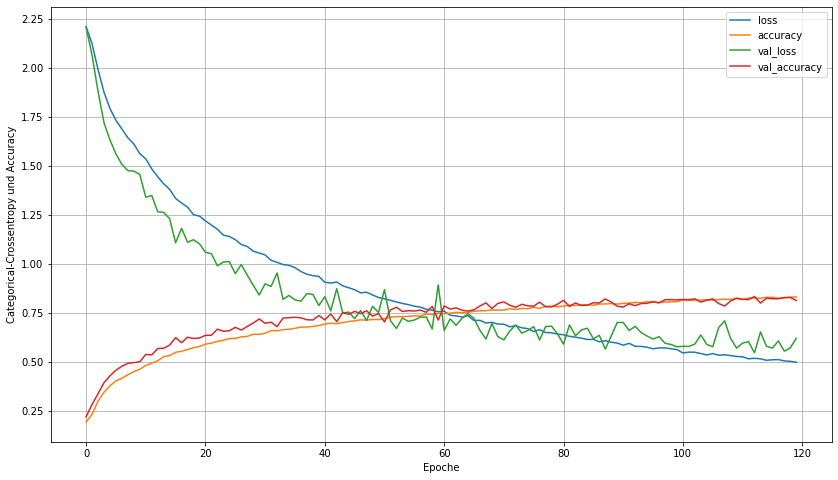

In [17]:
#Import of necessary functions
import pandas as pd

#Generate Pandas-DataFrame-Object
pdCNNModelHistory = pd.DataFrame(modelHistory.history)
display(pdCNNModelHistory.tail())

#show trainresults
pdCNNModelHistory.plot(figsize=(14, 8))
plt.xlabel('Epoche')
plt.ylabel('Categorical-Crossentropy und Accuracy')
plt.grid()
plt.show()

In [18]:
#ratio of train-/valid-error
CE_train = pdCNNModelHistory.get('loss') [-1:].to_numpy()
CE_eval = pdCNNModelHistory.get('val_loss')[-1:].to_numpy()
CE_ratio = CE_eval / CE_train

#ratio of train/valid-metric
Acc_train = pdCNNModelHistory.get('accuracy') [-1:].to_numpy()
Acc_eval = pdCNNModelHistory.get('val_accuracy')[-1:].to_numpy()
Acc_ratio = Acc_eval / Acc_train

#show error values
print('CE_train: ', CE_train)
print('CE_eval : ', CE_eval)
print('CE_ratio: ', CE_ratio)

#show metrics
print('Acc_train: ', Acc_train)
print('Acc_eval : ', Acc_eval)
print('Acc_ratio: ', Acc_ratio)

CE_train:  [0.49686271]
CE_eval :  [0.61888587]
CE_ratio:  [1.24558729]
Acc_train:  [0.83009195]
Acc_eval :  [0.81188875]
Acc_ratio:  [0.97807086]


In [19]:
#assign layers to variables
HiddenLayer1 = model.layers[0]

#show the weights and bias of the layers
WeightsLayer1, BiasLayer1   = HiddenLayer1.get_weights()
print('WeightsLayer1.shape:  ', WeightsLayer1.shape)
print('BiasLayer1.shape:     ', BiasLayer1.shape)

WeightsLayer1.shape:   (3, 3, 3, 32)
BiasLayer1.shape:      (32,)


In [20]:
#start TensorBoard-Server
%load_ext tensorboard
%tensorboard --inspect --logdir './TensorBoardLogs/'
%tensorboard --logdir './TensorBoardLogs/'

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stderr:
2021-01-04 02:25:34.821770: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_102.dll'; dlerror: cudart64_102.dll not found
2021-01-04 02:25:34.821886: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Contents of stdout:
Processing event files... (this can take a few minutes)

No event files found within logdir ./TensorBoardLogs/

Reusing TensorBoard on port 6006 (pid 9648), started 13 days, 6:26:24 ago. (Use '!kill 9648' to kill it.)

## Abspeichern des Modells

In [21]:
#Import of necessary functions
import joblib

os.chdir(rootDir)

#safe as TensorFlow-SavedModel
path = './models/tf_keras_savedmodel/'
model.save(filepath = path)

#safe as TensorFlow-HDF5-Modell
path = './models/tf_keras_hdf5/tfCNNModel'
model.save(filepath = path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/tf_keras_savedmodel/assets
INFO:tensorflow:Assets written to: ./models/tf_keras_hdf5/tfCNNModel\assets


# Schritt 4: Testen des Modells
### Laden des Modells

In [22]:
os.chdir(rootDir)

#load TensorFlow-SavedModel
path = './models/tf_keras_savedmodel/'
tfCNNModel_SM = tf.keras.models.load_model(path)
#load TensorFlow-HDF5-Modell
path = './models/tf_keras_hdf5/tfCNNModel'

### Erzeugen eines IDG-Objekts und des DFI-Objekts für die Testdaten:

In [23]:
#generate ImageDataGenerator-Object of testdata
test_datagen = ImageDataGenerator(rescale = rescale)

#set parameters
ImgDir      = testDir
class_mode  = None
shuffle     = False
batch_size  = 1

#generate DataFrameIterator-Objects of testdata
test_generator = test_datagen.flow_from_directory(directory     = ImgDir,
                                      target_size   = target_size,
                                      color_mode    = ImgColor,
                                      class_mode    = class_mode,
                                      shuffle       = shuffle,
                                      batch_size    = batch_size,
                                      seed          = seed)

#show dimensions of DataFrameIterator-Objects
print('len(test_generator):        ', len(test_generator))
print('test_generator[0].shape:    ', test_generator[0].shape)
print('test_generator[0][0].shape: ', test_generator[0][0].shape)

Found 21 images belonging to 1 classes.
len(test_generator):         21
test_generator[0].shape:     (1, 200, 200, 3)
test_generator[0][0].shape:  (200, 200, 3)


### Klassenvorhersage:

In [24]:
#class probabilities of train-, validation- and testdata
npLabel_train_prob = tfCNNModel_SM.predict(x = train_generator)
npLabel_eval_prob  = tfCNNModel_SM.predict(x = eval_generator)
npLabel_test_prob  = tfCNNModel_SM.predict(x = test_generator)

#determine class
npLabel_train_pred = npLabel_train_prob > 0.5
npLabel_eval_pred  = npLabel_eval_prob  > 0.5
npLabel_test_pred  = npLabel_test_prob  > 0.5

### Erzeugen der wahren Labelwerte zu den Trainings- und Evaluierungsdaten:

In [25]:
#Import of necessary functions
import numpy as np

#generate label-NumPy-Arrays with true label-values of train data
numBatches_train = len(train_generator)
npLabel_train    = np.zeros(shape = (0, numClasses), dtype = int)

for i in range (0, numBatches_train):
    npLabel_train = np.append(npLabel_train, train_generator[i][1], axis = 0)
print('npLabel_train.shape: ', npLabel_train.shape)

#generate label-NumPy-Arrays with true label-values of validation data
numBatches_eval = len(eval_generator)
npLabel_eval    = np.zeros(shape = (0, numClasses), dtype = int)

for i in range (0, numBatches_eval):
    npLabel_eval = np.append(npLabel_eval, eval_generator[i][1], axis = 0)
print('npLabel_eval.shape: ', npLabel_eval.shape)

npLabel_train.shape:  (20876, 10)
npLabel_eval.shape:  (5215, 10)


### Bestimmung der Genauigkeit:

In [26]:
#Import of necessary functions
from tensorflow.keras.metrics import Accuracy

#Generate Metrics-Objects
AccObject = Accuracy()

#Calculate metrics of train data
AccObject.update_state(y_true = npLabel_train, y_pred = npLabel_train_pred)
Acc_train = AccObject.result().numpy()
AccObject.reset_states()

#Calculate metrics of validation data
AccObject.update_state (y_true = npLabel_eval,  y_pred = npLabel_eval_pred)
Acc_eval  = AccObject.result().numpy()
AccObject.reset_states()

#Calculate ratio of error values
Acc_ratio_eval_train = Acc_eval / Acc_train

#Show error values an ratio
print('Acc_train:             ', Acc_train)
print('Acc_eval:              ', Acc_eval)
print('Acc_ratio_eval_train:  ', Acc_ratio_eval_train)

Acc_train:              0.83175415
Acc_eval:               0.83093
Acc_ratio_eval_train:   0.99900913


## Ausgabe von Test- und Evaluierungsbildern inkl. Vorhersage:

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


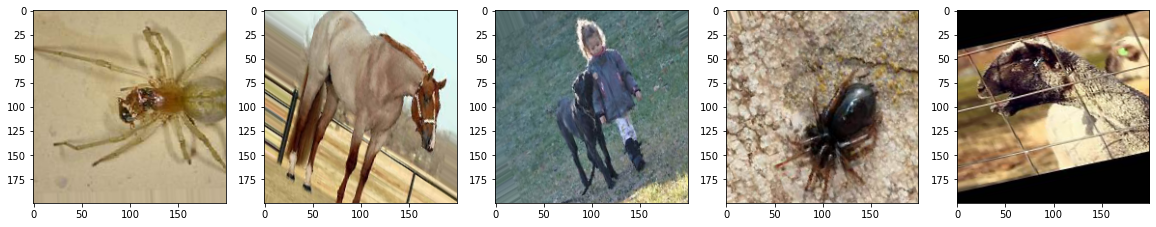

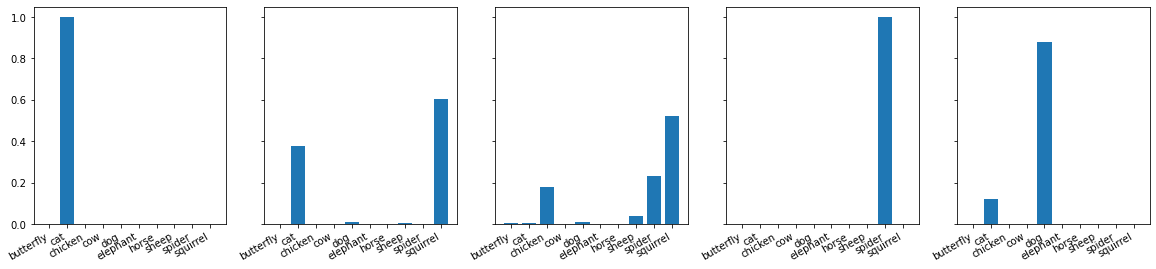

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


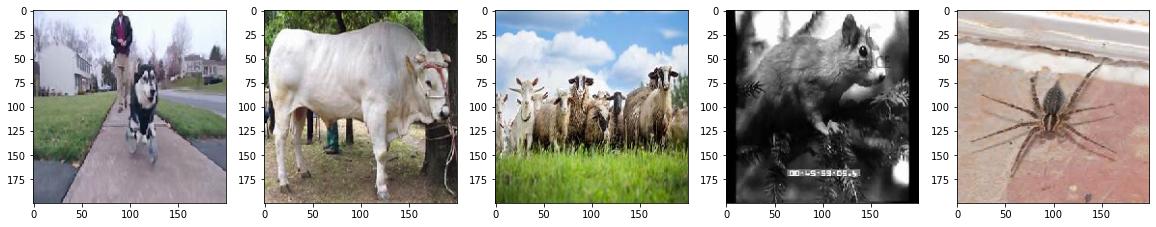

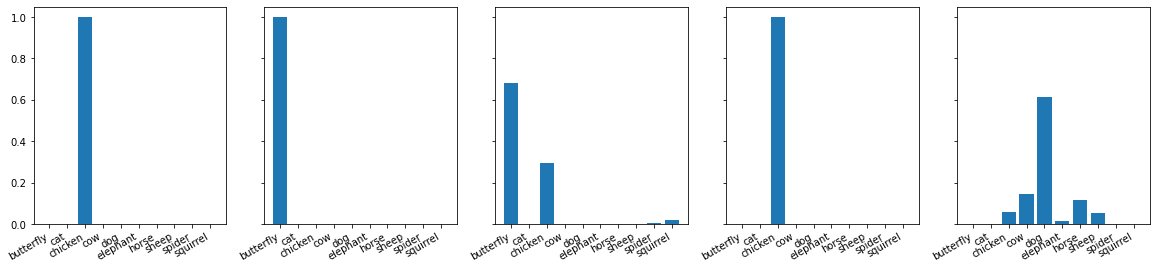

In [27]:
#set classnames
ClassNames = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
values = []

#load five train images
fig, axes = plt.subplots(1, 5, figsize = (20, 4))
fig, bar = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
for i in range (0, 5):
    values.clear()
    ImgMat    = train_generator[0][0][i]
    if    (ImgColor == 'rgb'):
        axes[i].imshow(X = ImgMat)
    elif  (ImgColor == 'grayscale'):
        axes[i].imshow(X = ImgMat, cmap = 'gray')

    for j in range (0, 10):
        values.append(npLabel_train_prob[i][j])
        
    bar[i].bar(ClassNames, values)
    plt.draw()
    bar[i].set_xticklabels(bar[i].get_xticklabels(), rotation=30, ha='right')
plt.show()

#load five validation images
fig, axes = plt.subplots(1, 5, figsize = (20, 4))
fig, bar = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
for i in range (0, 5):
    values.clear()
    ImgMat    = eval_generator[0][0][i]
    if    (ImgColor == 'rgb'):
        axes[i].imshow(X = ImgMat)
    elif  (ImgColor == 'grayscale'):
        axes[i].imshow(X = ImgMat, cmap = 'gray')
    
    for j in range (0, 10):
        values.append(npLabel_eval_prob[i][j])
        
    bar[i].bar(ClassNames, values)
    plt.draw()
    bar[i].set_xticklabels(bar[i].get_xticklabels(), rotation=30, ha='right')
plt.show()

## Ausgabe aller Testbilder inkl. Vorhersage:

In [23]:
#function for showing all test-images with predictions
import matplotlib.pyplot as plt

ClassNames = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
values=[]

def showImage(n):
    #5 figures per row for the first 20 images/plots, 1 figure in the last row
    col = 5 if (n<=20) else 1;
    
    fig, axes = plt.subplots(1, col, figsize = (20, 4))
    fig, bar = plt.subplots(1, col, figsize=(20, 4), sharey=True)
    for i in range (0, col):
        values.clear()
        ImgMat    = test_generator[i+n][0]
        if    (ImgColor == 'rgb'):
            axes[i].imshow(X = ImgMat)
        elif  (ImgColor == 'grayscale'):
            axes[i].imshow(X = ImgMat, cmap = 'gray')

        for j in range (0, 10):
            values.append(npLabel_test_prob[i+n][j])

        bar[i].bar(ClassNames, values)
        plt.draw()
        bar[i].set_xticklabels(bar[i].get_xticklabels(), rotation=30, ha='right')
    plt.show()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


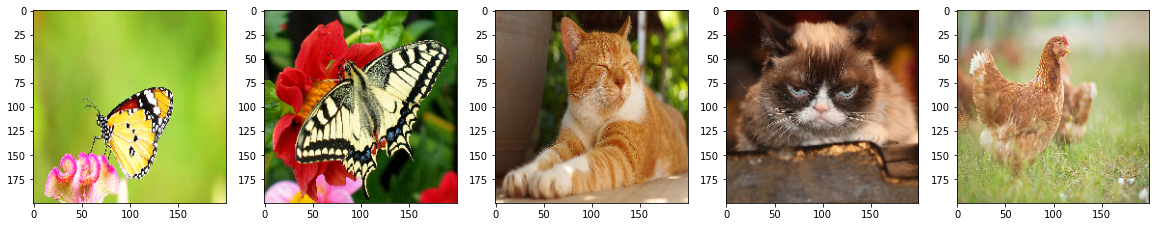

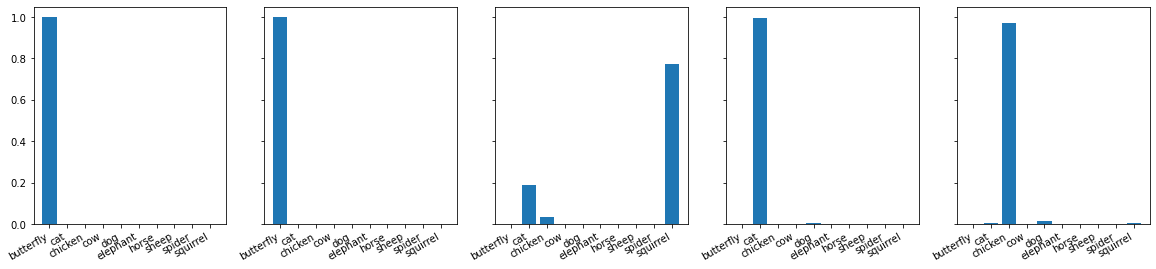

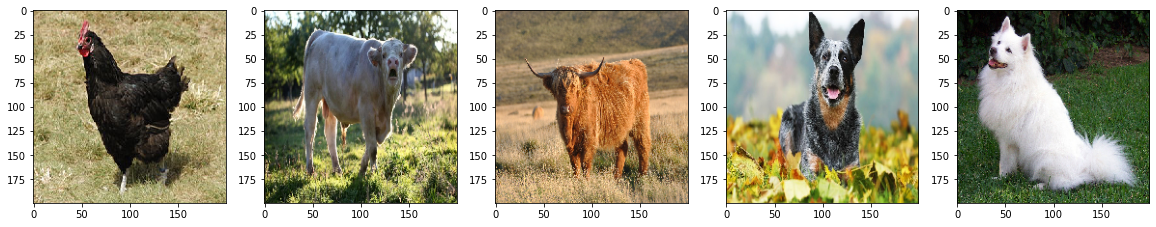

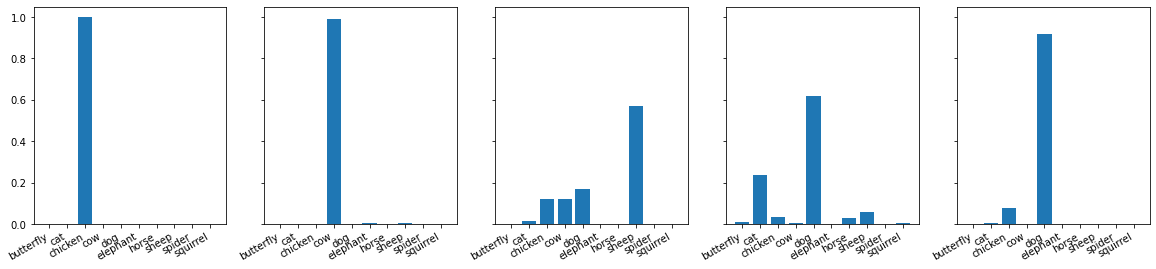

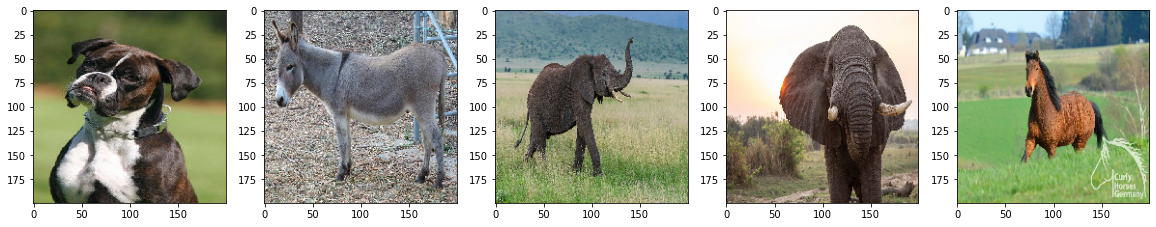

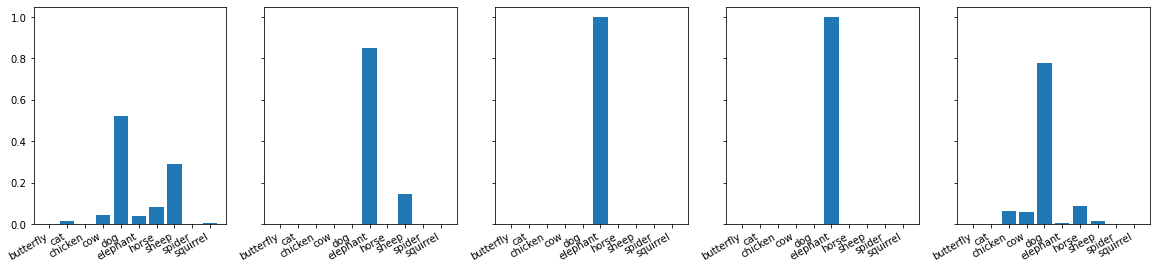

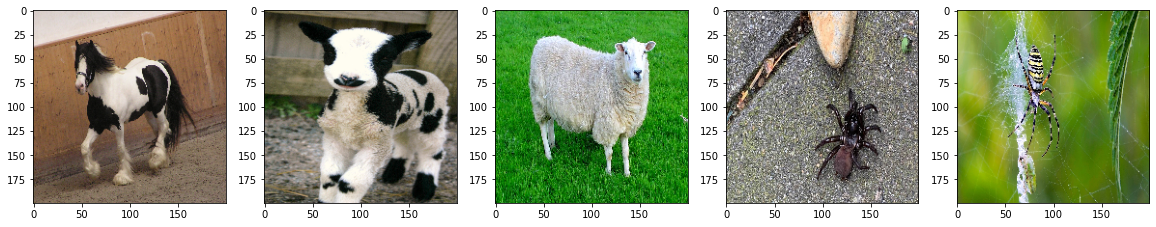

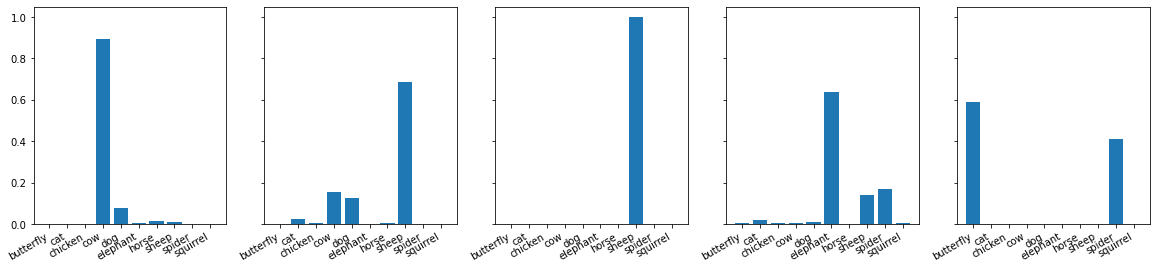

ValueError: Asked to retrieve element 21, but the Sequence has length 21

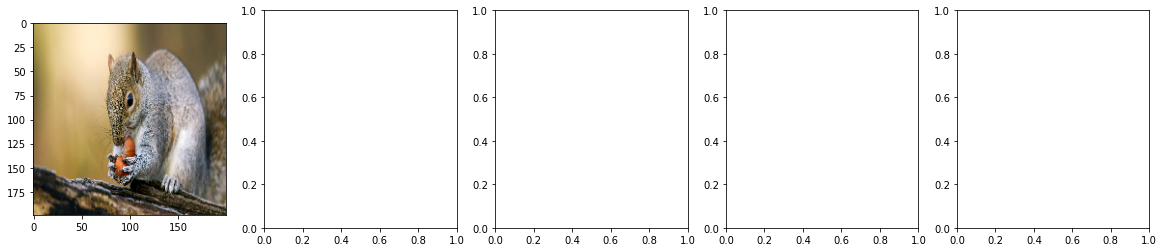

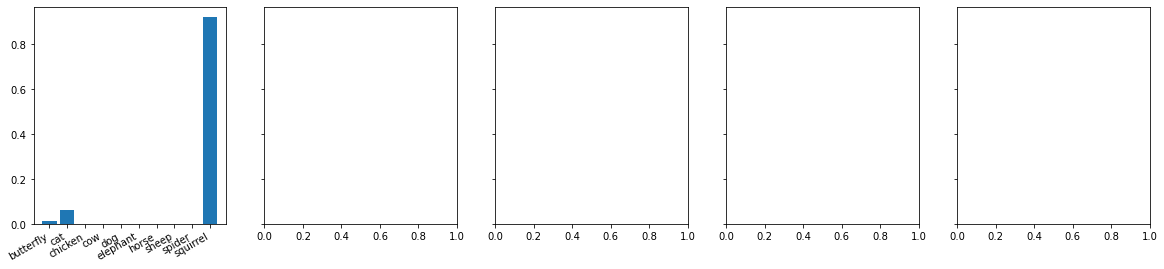

In [24]:
for i in range(0,20,5):
    showImage(i)

showImage(20)

# Für die Präsentation:
## Setzen der Arbeitspfade:

In [1]:
#Import of necessary functions
import os

#Set work directory, dataset-folders need to be placed in project-directory!
rootDir = os.getcwd()

testDir = rootDir +  "\Dataset_Test\Images_Test"
trainDir = rootDir + "\Dataset_Train_Eval\Images"

print("rootDir:", rootDir)
print("testDir:", testDir)
print("trainDir:", trainDir)

rootDir: C:\Users\Riccardo\source\Projektarbeit
testDir: C:\Users\Riccardo\source\Projektarbeit\Dataset_Test\Images_Test
trainDir: C:\Users\Riccardo\source\Projektarbeit\Dataset_Train_Eval\Images


## Laden des Modells:

In [2]:
import tensorflow as tf

#load TensorFlow-SavedModel
path = './models/tf_keras_savedmodel/'
tfCNNModel_SM = tf.keras.models.load_model(path)
#load TensorFlow-HDF5-Modell
path = './models/tf_keras_hdf5/tfCNNModel'

## Erzeugen des IDG-Objekts und des DFI-Objekts:

In [3]:
#Import of necessary functions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#set parameters
rescale            = 1.0 / 255.0
validation_split   = 0.20
rotation_range     = 30
zoom_range         = 0.3
vertical_flip      = False
horizontal_flip    = True
width_shift_range  = [-10, 10]
height_shift_range = [-10, 10]
fill_mode          = 'nearest'
cval               = 0
ImgWidth           = 200
ImgHeight          = 200
ImgColor           = 'rgb'
target_size        = (ImgHeight, ImgWidth)
class_mode         = 'categorical'
shuffle            = False
batch_size         = 32
seed               = 1
classes            =  ['000000001-butterfly',
                       '000000002-cat',
                       '000000003-chicken',
                       '000000004-cow',
                       '000000005-dog',
                       '000000006-elephant',
                       '000000007-horse',
                       '000000008-sheep',
                       '000000009-spider',
                       '000000010-squirrel']

#generate ImageDataGenerator-Object of testdata
test_datagen = ImageDataGenerator(rescale = rescale)

#set parameters
ImgDir      = testDir
class_mode  = None
shuffle     = False
batch_size  = 1

#generate DataFrameIterator-Objects of testdata
test_generator = test_datagen.flow_from_directory(directory     = ImgDir,
                                      target_size   = target_size,
                                      color_mode    = ImgColor,
                                      class_mode    = class_mode,
                                      shuffle       = shuffle,
                                      batch_size    = batch_size,
                                      seed          = seed)

#show dimensions of DataFrameIterator-Objects
print('len(test_generator):        ', len(test_generator))
print('test_generator[0].shape:    ', test_generator[0].shape)
print('test_generator[0][0].shape: ', test_generator[0][0].shape)

Found 21 images belonging to 1 classes.
len(test_generator):         21
test_generator[0].shape:     (1, 200, 200, 3)
test_generator[0][0].shape:  (200, 200, 3)


## Vorhersage der Klassenzugehörigkeit:

In [4]:
# determine class probabilities of testdata
npLabel_test_prob  = tfCNNModel_SM.predict(x = test_generator)

# determine class
npLabel_test_pred  = npLabel_test_prob  > 0.5

## Ausgabe der Testbilder inkl. Vorhersage:

In [21]:
#function for showing all test-images with predictions
import matplotlib.pyplot as plt

ClassNames = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
values=[]

def showImage(n):
    #5 figures per row for the first 20 images/plots, 1 figure in the last row
    col = 5 if (n<=20) else 1;
    
    fig, axes = plt.subplots(1, col, figsize = (20, 4))
    fig, bar = plt.subplots(1, col, figsize=(20, 4), sharey=True)
    for i in range (0, col):
        values.clear()
        ImgMat    = test_generator[i+n][0]
        if    (ImgColor == 'rgb'):
            axes[i].imshow(X = ImgMat)
        elif  (ImgColor == 'grayscale'):
            axes[i].imshow(X = ImgMat, cmap = 'gray')

        for j in range (0, 10):
            values.append(npLabel_test_prob[i+n][j])

        bar[i].bar(ClassNames, values)
        plt.draw()
        bar[i].set_xticklabels(bar[i].get_xticklabels(), rotation=30, ha='right')
    plt.show()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


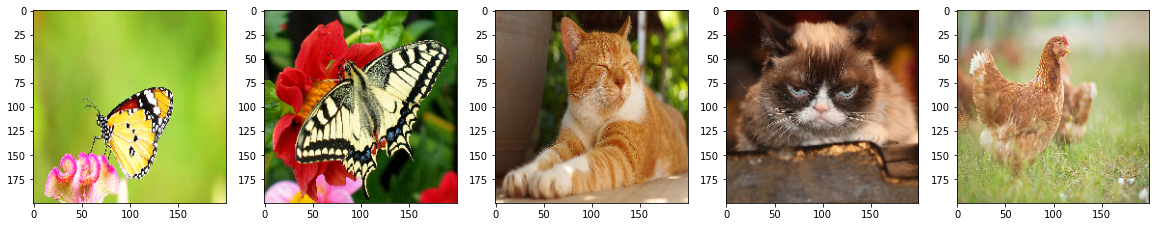

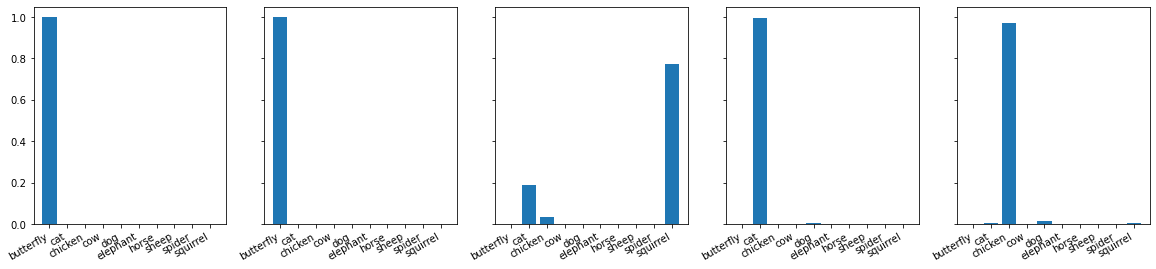

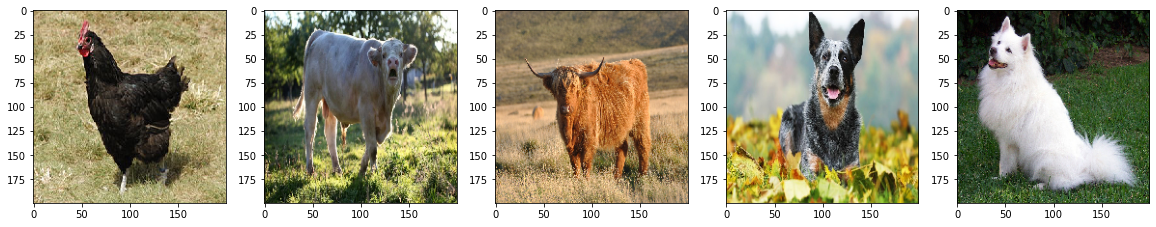

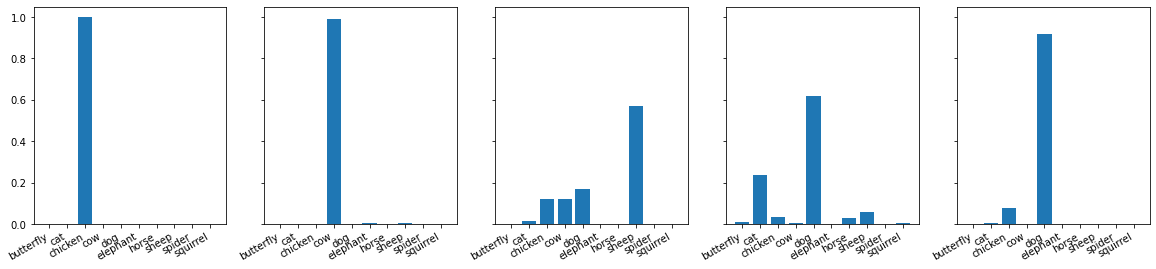

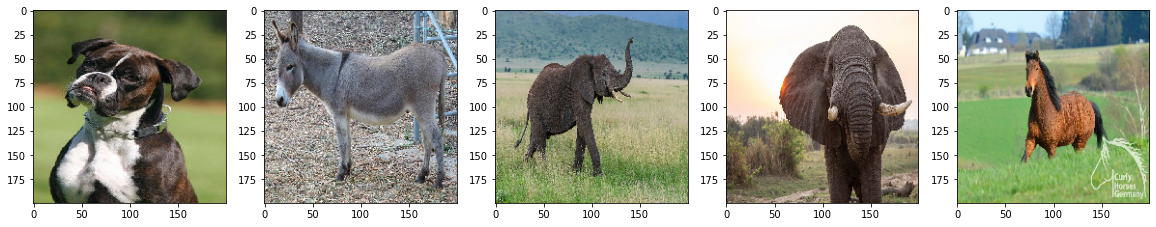

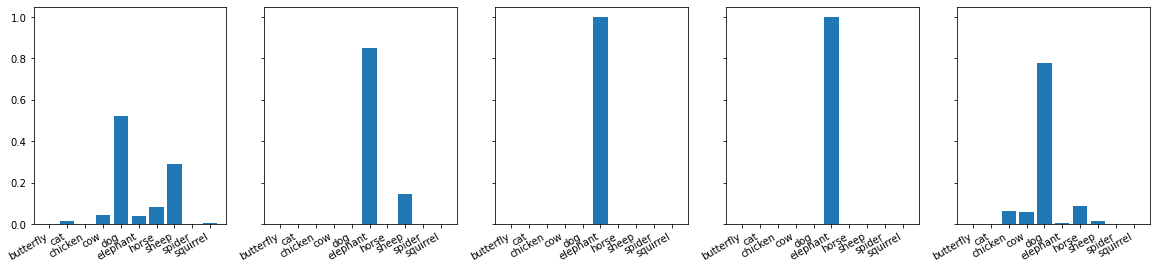

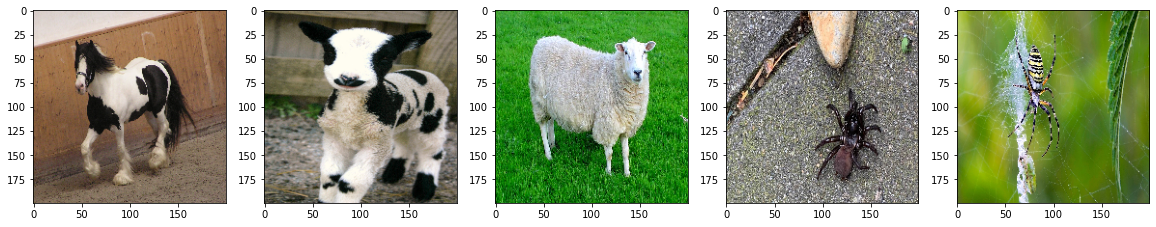

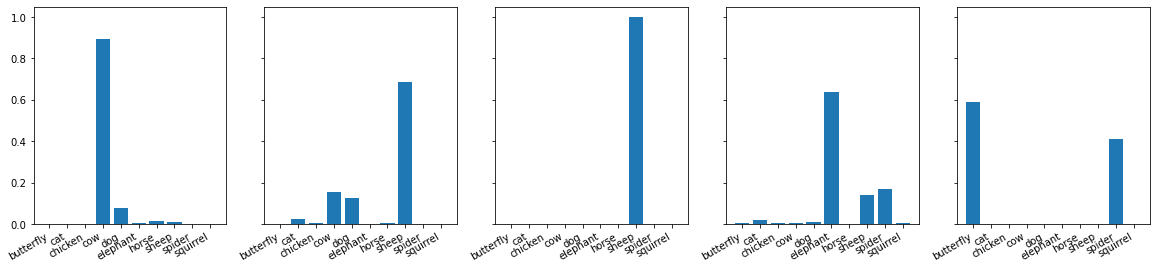

ValueError: Asked to retrieve element 21, but the Sequence has length 21

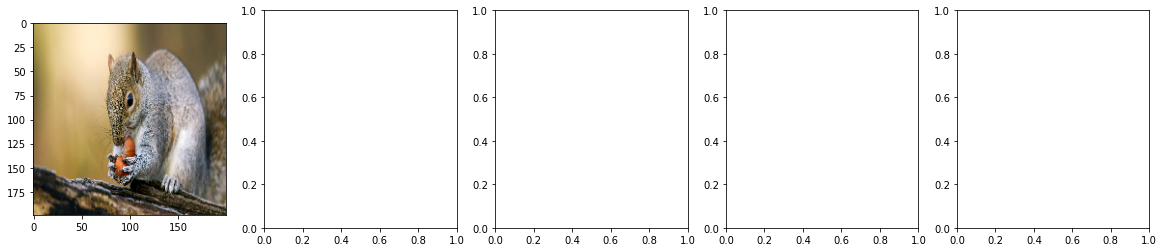

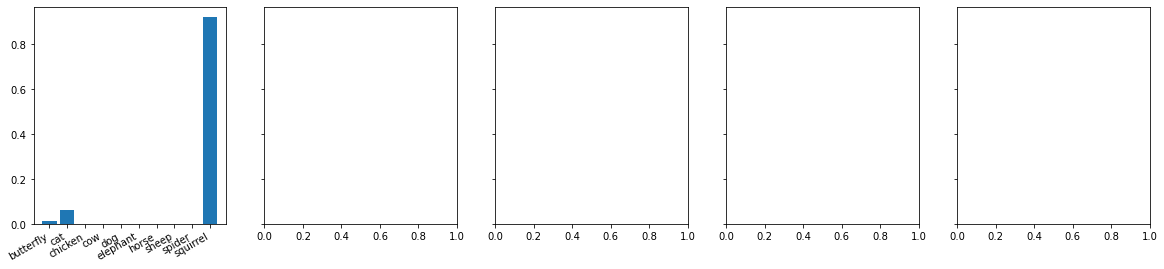

In [22]:
for i in range(0,20,5):
    showImage(i)

showImage(20)